In [1]:
# Useful starting lines
%matplotlib inline
import datetime
from costs import compute_loss
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%load_ext autoreload

%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = "train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
# standardize the data
tX_std = standardize(tX)

# Implement ML methods

## Least squares GD

In [3]:
def compute_gradient(y, tx, w):
    """
    Compute the gradient.
    
    :param y: labels
    :param tx: features
    :param w: weights
    :return grad: gradient
    """
    grad = (-1/len(y))*tx.T@(y-tx@w)
    return grad
    # ***************************************************


def least_squares_GD(y, tx, initial_w, max_iter, gamma):
    """
    Least square gradient descent
    
    :param y: labels
    :param tx: features
    :param initial_w: initial weights
    :param max_iter: max number of iterations
    :param gamma: learning rate
    :return ws: weights
    :return ls: loss
    """    
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iter):
        gradient = compute_gradient(y,tx,w)
        loss = compute_loss(y,tx,w)
        w = w-gamma*gradient
        ws.append(w)
        losses.append(loss)
        
    return np.array(ws)[-1], np.array(losses)

## Least square SGD

In [4]:

def compute_stoch_gradient(y, tx, w):
    """
    Compute the gradient.
    
    :param y: labels
    :param tx: features
    :param w: weights
    :return grad: gradient
    """    # ***************************************************
    e = y-tx@w
    grad = -1/len(y)*tx.T@e
    return grad
    # ***************************************************


def least_squares_SGD(y, tx, initial_w, batch_size, max_iter, gamma):
    """
    Least square stochastic gradient descent
    
    :param y: labels
    :param tx: features
    :param initial_w: initial weights
    :param batch_size: 1 if sgd
    :param max_iter: max number of iterations
    :param gamma: learning rate
    :return ws: weights
    :return ls: loss
    """   
    ws = []
    losses = []
    w = initial_w
    for n_iter in range(max_iter):
        # compute random batch
        a = batch_iter(y, tx, batch_size, num_batches=1, shuffle=True)
        a = list(a)
        tx2, y2 = a[0][1], a[0][0]
        # compute gradient & loss
        grad = compute_stoch_gradient(y2,tx2,w)
        loss= compute_loss(y2, tx2, w)
        # update gradient
        w = w-gamma*grad
        # store w and loss
        ws.append(w)
        losses.append(loss)


    return np.array(ws)[-1], np.array(losses)

## Least square
computed by solving for w:  X<sup>T</sup>X * w = X<sup>T</sup>y

In [5]:
def least_square(y, tx):
    """
    Solves the closed form least square equation to obtain optimal weights
    
    :param y: labels
    :param tx: features
    :returns w,l: weights and loss of the model
    """
    w = np.linalg.solve(tx.T@tx,tx.T@y)
    l = compute_loss(y, tx, w)
    return w, l


## Ridge regression

In [6]:
def ridge_regression(y, tx, lambda_):
    """
    Solves the closed form of Ridge regression equation to obtain optimal weights
    
    :param y: labels
    :param tx: features
    :param lambda_: regulizer
    :returns w,l: weights and loss of the model
    """
    w = np.linalg.solve(tx.T@tx+lambda_*np.eye(tx.shape[1]),tx.T@y)
    l = compute_loss(y, tx, w)
    return w, l


## Logistic regression

In [7]:
def sigmoid(z):
    """
    sigmoid function
    
    :param z: 
    :return z:
    """
    return 1/(1+np.exp(-z))
def update_weights(y, tx, w, gamma):
    """
    Update weights function for logistic regression
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param gamma: learning rate
    
    :return w: new updated weights
    """ 
    #probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    gradient = np.dot(tx.T,  probabilities - y)
    w -= gradient*gamma / len(tx)
    return w

def LR_loss_function(y, tx, w):
    """
    Computes logistic loss
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    
    :return loss: logistic loss
    """ 
    #probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    #the error when label=1
    error1 = -y*np.log(probabilities)
    #the error when label=-1
    error2 = (1-y)*np.log(1-probabilities)
    #return average of sum of costs
    loss = (error1-error2).mean()
    return loss


# logistic regression function
def logistic_regression(y,tx, initial_w,  max_iter, gamma):
    """
    Logistic regression function
    
    :param tx: features matrix
    :param y: labels vector
    :param initial_w: initial weights
    :param max_iter: number of iterations
    :param gamma: learning rate

    :return ls: last loss  computed
    :return ws: last weights computed
    """ 
    losses = []
    ws = []
    for iter_n in range(max_iter):
        w = update_weights(y, tx, initial_w, gamma)
        loss = LR_loss_function(y, tx, w)
        losses.append(loss)
        ws.append(w)
    ls, wes  = np.array(losses), np.array(ws)
    return wes[-1],ls



## Regularized logistic regression

In [8]:
def reg_LR_update_weights(y, tx, w, gamma, lambda_):
    """
    Update weights function for  regularized logistic regression
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param gamma: learning rate
    :param lambda_: regulizer
    
    :return w: new updated weights
    """ 
    # probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    gradient = np.dot(tx.T,  probabilities - y) + lambda_ * w
    w -= gradient*gamma / len(tx)
    return w

def reg_LR_loss_function(y, tx, w, lambda_):
    """
    Computes logistic loss
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param lambda_: regulizer
    
    :return w: logistic loss
    """ 
    # probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    # the error when label=1
    error1 = -y*np.log(probabilities)
    # the error when label=0
    error2 = (1-y)*np.log(1-probabilities)
    # return average of sum of costs
    return (error1-error2).mean()+lambda_/2*np.dot(w.T,w)/ len(tx)


# regularized logistic regression function
def reg_logistic_regression(y,tx, initial_w,max_iter, gamma,lambda_):
    """
    Regularized logistic regression function
    
    :param tx: features matrix
    :param y: labels vector
    :param initial_w: initial weights
    :param max_iter: number of iterations
    :param gamma: learning rate
    :param lambda_: regulizer

    :return ls: last loss  computed
    :return ws: last weights computed
    """ 
    losses = []
    ws = []
    for iter_n in range(max_iter):
        if(iter_n > 800):
            gamma = gamma-gamma/30
        w = reg_LR_update_weights(y, tx, initial_w, gamma,lambda_)
        loss = reg_LR_loss_function(y, tx, w, lambda_)
        losses.append(loss)
        ws.append(w)
    ls, wes  = np.array(losses), np.array(ws)
    return wes[-1],ls


# Useful functions

In [9]:
def compute_accuracy(y_pred, y):
    """
    compute the accuracy
    
    :param y_pred: predictions
    :param y: real labels
    
    :return acc: accuracy
    """
    # y_pred - y & count 0
    arr = np.array(y_pred) - np.array(y)
    acc = np.count_nonzero(arr==0) / len(y)
    return acc


def build_k_indices(y, k_fold, seed):
    """
    build k indices for k-fold.
    
    :param y: labels
    :param k_fold: number of folds
    :param seed: seed for randomization
    
    :return k_indices: indices 
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def build_poly(x, degree):
    """
    polynomial basis functions for input data x, for j=0 up to j=degree.
    
    :param x: matrix 
    :param degree: degree of expansion
    """
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly


def cross_validation(y, x, k_indices, k, degree, regression_method, **kwargs):
    """
    Computes cross validation on a given data set using a given regression method, and computes the
    weights, the train loss, the test loss, and the train and loss accuracy
    if the degree is not none, it will perform feature expansion on the data set
    
    :param y: labels vector
    :param tx: features matrix
    :param k_indices: k_fold already randomly computed indices
    :param degree: degree of polynomial expansion
    :param logistic: boolean; if true, the loss used is the logistic one
    :param **kwargs: differents parameters such as the regulizer lambda or the learning rate gamma
    """
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    train_indice = train_indice.reshape(-1)
    
    y_test = y[test_indice]
    y_train = y[train_indice]
    x_test = x[test_indice]
    x_train = x[train_indice]
    
    if degree != None:
        x_train = build_poly(x_train, degree)
        x_test = build_poly(x_test, degree)
    

    w_initial = np.zeros(x_train.shape[1])
    kwargs = kwargs
    kwargs['initial_w'] = w_initial

    
    if regression_method is reg_logistic_regression:
        w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
        loss_test = reg_LR_loss_function(y_test, x_test, w ,kwargs['lambda_'])
        
    elif regression_method is logistic_regression:
        w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
        loss_test = LR_loss_function(y_test, x_test, w)
        
    elif regression_method is least_square:
        w, loss_train = regression_method(y = y_train, tx = x_train)
        loss_test = compute_loss(y_test, x_test, w)
        
    elif regression_method is ridge_regression:
        w, loss_train = regression_method(y_train,x_train, kwargs['lambda_'])
        loss_test = compute_loss(y_test, x_test, w)
    else: 
        w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
        loss_test = compute_loss(y_test, x_test, w)

        
    y_train_pred = predict_labels(w, x_train)
    y_test_pred = predict_labels(w, x_test)
    y_test = (y_test*2)-1
    y_train = (y_train*2)-1
    accuracy_train = compute_accuracy(y_train_pred, y_train)
    accuracy_test = compute_accuracy(y_test_pred, y_test)
    return w, loss_train, loss_test, accuracy_train, accuracy_test

def evaluate(tx, wf, degree):
    
    """
    function to evaluate weights over all the train model
    
    :param tx: train features
    :param wf: wights to evaluate
    :param degree: degree of expansion
    :return acc: accuracy of the weights over the train model
    """
    if degree is not None:
        tx =build_poly(tx, degree)
    if isinstance(wf, list):
        wk =np.mean(wf, axis =0)

    else:
        wk = wf
                
    y_pred = predict_labels(wk, tx)
    acc = compute_accuracy(y_std*2-1, y_pred)
    return acc
def remove_outliers_IQR(tx, y, high,low):
    """
    removes outliers using IQR
    
    :param tx: features
    :param y: labels
    :param high: high IQR
    :param low: low IQR
    :returns tX, Y: features and labels without outliers
    """
    Q1 = np.quantile(tX,low,axis = 0)
    Q3 = np.quantile(tX,high, axis = 0)
    IQR = Q3 - Q1
    tX_no_outliers = tX[~((tX < (Q1 - 1.5 * IQR)) |(tX > (Q3 + 1.5 * IQR))).any(axis=1)]
    y_no_outliers = y_std[~((tX < (Q1 - 1.5 * IQR)) |(tX > (Q3 + 1.5 * IQR))).any(axis=1)]
    return tX_no_outliers, y_no_outliers

def replace(tX, value):
    """
    Replaces invalid values with the mean of all the values in the cooresponding feature 

    :param tX: features
    :param value: value to replace
    :return tX: tX with replaced values
    """
    for i in range(tX.shape[1]):
        data = tX[:, i].copy()
        np.delete(data, np.where(data == value))  
        data_median = np.median(data)  
        tX[tX[:, i] == value,i] = data_median  
    return tX

def standardize_test(tx, tx_test):
    """
    Standardize wrt the tx train mean and std
    
    :param tx: train features
    :param tx_test: test features
    :return: std_data: standardized version of tx_test
    """
    value = -999
    tx_test = replace(tx_test, value)
    centered_data = tx_test - np.mean(tx, axis=0)
    std_data = centered_data / np.std(tx, axis=0)
    return std_data

# Train 

## Train function

In [10]:
def train(model,y,tx,k_fold,degree,seed=0, **kwargs):
    """
    regularized logistic regression function 
    
    :param Model: model that we'll use
    :param y: labels vector
    :param tx: features matrix
    :param k_fold: number of folds
    :param degree: degree of polynomial expansion
    :param seed: random seed for cross validation split
    :param **kwargs: multiple possible parameters
    
    :return wf: final weights 
    """    
    weights = []
    losses_train = []
    losses_test = []
    accuracies_train = []
    accuracies_test = []
    
    logistic = False
    if model is logistic_regression or model is reg_logistic_regression:
        logistic = True
    
    k_indices = build_k_indices(y, k_fold, seed)
    for k in tqdm(range(k_fold)):
        w, loss_train, loss_test, accuracy_train, accuracy_test = cross_validation(y, tx, k_indices, k, degree, model, **kwargs)
        weights.append(w)
        losses_train.append(loss_train)
        losses_test.append(loss_test)
        accuracies_train.append(accuracy_train)
        accuracies_test.append(accuracy_test)
    leg = ["train loss "+str(i) for i in range(k_fold)]
    plt.legend(leg)
    plt.plot(losses_train[-1])    
    print("<-"+"-"*75+"->")
    if degree is not None:
        degree = int(degree)
    
    print("{:15.14}|{:15.14}|{:15.14}|{:15.14}|{:15.14}".format("Train losses","Test losses","Train accuracy","Test Accuracy", "Evaluation"))
    for i in range(k_fold):
        if model is least_square or model is ridge_regression:
            print("{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}".format(losses_train[i], losses_test[i] ,accuracies_train[i], accuracies_test[i], evaluate(tX_std, np.array(weights[i]), degree)))
        else:
            print("{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}|{:< 15f}".format(losses_train[i][-1], losses_test[i] ,accuracies_train[i], accuracies_test[i], evaluate(tX_std, np.array(weights[i]), degree)))
        print("{:15.1}|{:15.14}|{:15.14}|{:15.14}|{:15.14}".format("","","","",""))
    print("<-"+"-"*75+"->")
    print(f"evaluation mean w: {evaluate(tX_std, weights, degree)}")

    return weights, sum(accuracies_train)/len(accuracies_train),sum(accuracies_test)/len(accuracies_test)
    

# Testing without outliers

In [11]:
DATA_TRAIN_PATH = "train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y_std = (y+1)/2


tX_no_outliers, y_no_outliers = remove_outliers_IQR(tX,y_std, 0.85, 0)

tX_no_outliers_std = standardize(tX_no_outliers)


## test least square

In [ ]:
w_ls = train(least_square,y_std,tX_std,5,None,seed=0)


## test least squares Gradient descent 

In [ ]:
w_lsGD = train(least_squares_GD,y_no_outliers,tX_no_outliers_std,5,None,gamma=0.0277184057,seed=0, max_iter = 200)


## test least squares Stochastic Gradient descent 


In [ ]:
w_lsSGD = train(least_squares_SGD,y_no_outliers,tX_no_outliers_std,5,None,gamma=0.0257184057,seed=0,batch_size = 10000, max_iter = 200)


## test Logistic regression 


In [ ]:
w_LR = train(logistic_regression,y_no_outliers,tX_no_outliers_std,5,2,gamma=0.2307184057,seed=0, max_iter = 200)


## test regularized Logistic regression 


In [ ]:
w_regLR = train(reg_logistic_regression,y_no_outliers,tX_no_outliers_std,5,2,gamma=0.227184057,seed=0, max_iter = 300, lambda_ = 0.000770)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Done about :0.0


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.332305      | 0.335568      | 0.645683      | 0.642712      | 0.638600      
               |               |               |               |               
 0.333582      | 0.330413      | 0.644919      | 0.646132      | 0.638392      
               |               |               |               |               
 0.332866      | 0.333454      | 0.645443      | 0.643289      | 0.638460      
               |               |               |               |               
 0.332807      | 0.333793      | 0.644967      | 0.646474      | 0.638308      
               |               |               |               |               
 0.333318      | 0.331524      | 0.644983      | 0.647051      | 0.638580      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.309356      | 0.312720      | 0.672579      | 0.670735      | 0.660416      
               |               |               |               |               
 0.310428      | 0.307883      | 0.672643      | 0.673300      | 0.661024      
               |               |               |               |               
 0.310047      | 0.310144      | 0.672985      | 0.669880      | 0.660592      
               |               |               |               |               
 0.310004      | 0.310181      | 0.672825      | 0.674433      | 0.661588      
               |               |               |               |               
 0.310213      | 0.308828      | 0.672584      | 0.674839      | 0.661428      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.287057      | 0.289822      | 0.703247      | 0.704551      | 0.697972      
               |               |               |               |               
 0.287847      | 0.286465      | 0.703060      | 0.702948      | 0.697552      
               |               |               |               |               
 0.287631      | 0.287305      | 0.704257      | 0.698972      | 0.697748      
               |               |               |               |               
 0.287643      | 0.287389      | 0.703028      | 0.703183      | 0.697564      
               |               |               |               |               
 0.287764      | 0.287027      | 0.702344      | 0.705940      | 0.697312      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277845      | 0.280220      | 0.721384      | 0.724216      | 0.718292      
               |               |               |               |               
 0.278449      | 0.277668      | 0.721758      | 0.721587      | 0.717900      
               |               |               |               |               
 0.278346      | 0.278145      | 0.723479      | 0.715324      | 0.717984      
               |               |               |               |               
 0.278287      | 0.278285      | 0.721817      | 0.722998      | 0.718008      
               |               |               |               |               
 0.278547      | 0.277465      | 0.720764      | 0.725071      | 0.717780      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279849      | 0.722308      | 0.725263      | 0.405356      
               |               |               |               |               
 0.277960      | 0.277427      | 0.722522      | 0.723169      | 0.628936      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724542      | 0.716777      | 0.658264      
               |               |               |               |               
 0.277835      | 0.277910      | 0.722944      | 0.723382      | 0.622236      
               |               |               |               |               
 0.278109      | 0.276824      | 0.722004      | 0.725926      | 0.621244      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279847      | 0.722276      | 0.725285      | 0.489264      
               |               |               |               |               
 0.277960      | 0.277427      | 0.722527      | 0.723169      | 0.651768      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724531      | 0.716863      | 0.703948      
               |               |               |               |               
 0.277836      | 0.277907      | 0.722918      | 0.723382      | 0.632912      
               |               |               |               |               
 0.278110      | 0.276817      | 0.721881      | 0.725841      | 0.630060      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279846      | 0.722282      | 0.725263      | 0.611680      
               |               |               |               |               
 0.277960      | 0.277427      | 0.722549      | 0.723169      | 0.671480      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724542      | 0.716863      | 0.714240      
               |               |               |               |               
 0.277836      | 0.277906      | 0.722901      | 0.723297      | 0.644956      
               |               |               |               |               
 0.278110      | 0.276816      | 0.721881      | 0.725883      | 0.640356      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279846      | 0.722292      | 0.725263      | 0.687884      
               |               |               |               |               
 0.277960      | 0.277427      | 0.722549      | 0.723190      | 0.701528      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724542      | 0.716863      | 0.718040      
               |               |               |               |               
 0.277836      | 0.277906      | 0.722923      | 0.723297      | 0.665592      
               |               |               |               |               
 0.278110      | 0.276816      | 0.721891      | 0.725926      | 0.659092      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279846      | 0.722298      | 0.725263      | 0.712948      
               |               |               |               |               
 0.277960      | 0.277427      | 0.722554      | 0.723169      | 0.714696      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724537      | 0.716863      | 0.719116      
               |               |               |               |               
 0.277836      | 0.277906      | 0.722950      | 0.723297      | 0.699676      
               |               |               |               |               
 0.278111      | 0.276815      | 0.721870      | 0.725926      | 0.691452      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279845      | 0.722303      | 0.725242      | 0.718456      
               |               |               |               |               
 0.277960      | 0.277427      | 0.722549      | 0.723169      | 0.718024      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724547      | 0.716863      | 0.719804      
               |               |               |               |               
 0.277836      | 0.277906      | 0.722944      | 0.723276      | 0.714224      
               |               |               |               |               
 0.278111      | 0.276815      | 0.721870      | 0.725947      | 0.711184      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279845      | 0.722292      | 0.725242      | 0.719652      
               |               |               |               |               
 0.277960      | 0.277428      | 0.722549      | 0.723190      | 0.719124      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724558      | 0.716842      | 0.719660      
               |               |               |               |               
 0.277836      | 0.277906      | 0.722939      | 0.723276      | 0.718028      
               |               |               |               |               
 0.278111      | 0.276815      | 0.721897      | 0.725969      | 0.716992      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279843      | 0.722282      | 0.725263      | 0.719880      
               |               |               |               |               
 0.277960      | 0.277428      | 0.722565      | 0.723169      | 0.719660      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724553      | 0.716799      | 0.719604      
               |               |               |               |               
 0.277836      | 0.277907      | 0.722976      | 0.723318      | 0.719332      
               |               |               |               |               
 0.278111      | 0.276815      | 0.721897      | 0.725947      | 0.718908      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277355      | 0.279839      | 0.722292      | 0.725242      | 0.719944      
               |               |               |               |               
 0.277960      | 0.277430      | 0.722597      | 0.723147      | 0.719600      
               |               |               |               |               
 0.277891      | 0.277675      | 0.724542      | 0.716756      | 0.719564      
               |               |               |               |               
 0.277836      | 0.277909      | 0.722971      | 0.723340      | 0.719808      
               |               |               |               |               
 0.278111      | 0.276815      | 0.721902      | 0.725969      | 0.719536      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277356      | 0.279832      | 0.722335      | 0.725285      | 0.720008      
               |               |               |               |               
 0.277961      | 0.277433      | 0.722634      | 0.723169      | 0.719600      
               |               |               |               |               
 0.277892      | 0.277676      | 0.724558      | 0.716777      | 0.719608      
               |               |               |               |               
 0.277837      | 0.277912      | 0.723019      | 0.723468      | 0.719800      
               |               |               |               |               
 0.278111      | 0.276815      | 0.721913      | 0.726012      | 0.719624      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277359      | 0.279820      | 0.722330      | 0.725306      | 0.720028      
               |               |               |               |               
 0.277963      | 0.277440      | 0.722597      | 0.723126      | 0.719652      
               |               |               |               |               
 0.277894      | 0.277678      | 0.724585      | 0.716756      | 0.719640      
               |               |               |               |               
 0.277839      | 0.277920      | 0.722944      | 0.723340      | 0.719860      
               |               |               |               |               
 0.278114      | 0.276817      | 0.721988      | 0.726054      | 0.719620      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277368      | 0.279806      | 0.722383      | 0.725499      | 0.720020      
               |               |               |               |               
 0.277967      | 0.277451      | 0.722613      | 0.723190      | 0.719604      
               |               |               |               |               
 0.277900      | 0.277685      | 0.724601      | 0.716649      | 0.719632      
               |               |               |               |               
 0.277844      | 0.277934      | 0.722944      | 0.723447      | 0.719868      
               |               |               |               |               
 0.278120      | 0.276823      | 0.722132      | 0.726076      | 0.719552      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277383      | 0.279794      | 0.722458      | 0.725691      | 0.720032      
               |               |               |               |               
 0.277976      | 0.277463      | 0.722682      | 0.723105      | 0.719536      
               |               |               |               |               
 0.277911      | 0.277696      | 0.724724      | 0.716457      | 0.719616      
               |               |               |               |               
 0.277852      | 0.277954      | 0.723024      | 0.723746      | 0.719752      
               |               |               |               |               
 0.278132      | 0.276838      | 0.722175      | 0.725926      | 0.719520      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277403      | 0.279786      | 0.722437      | 0.725862      | 0.720000      
               |               |               |               |               
 0.277988      | 0.277470      | 0.722704      | 0.723233      | 0.719624      
               |               |               |               |               
 0.277925      | 0.277710      | 0.724676      | 0.716628      | 0.719496      
               |               |               |               |               
 0.277864      | 0.277976      | 0.722939      | 0.723746      | 0.719744      
               |               |               |               |               
 0.278146      | 0.276860      | 0.722185      | 0.725776      | 0.719424      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277425      | 0.279782      | 0.722415      | 0.725712      | 0.720052      
               |               |               |               |               
 0.278005      | 0.277471      | 0.722693      | 0.723147      | 0.719644      
               |               |               |               |               
 0.277941      | 0.277728      | 0.724756      | 0.716521      | 0.719512      
               |               |               |               |               
 0.277878      | 0.277999      | 0.722901      | 0.723960      | 0.719720      
               |               |               |               |               
 0.278160      | 0.276890      | 0.722185      | 0.725712      | 0.719452      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.277450      | 0.279785      | 0.722362      | 0.725969      | 0.720036      
               |               |               |               |               
 0.278029      | 0.277471      | 0.722720      | 0.723404      | 0.719684      
               |               |               |               |               
 0.277961      | 0.277749      | 0.724761      | 0.716521      | 0.719544      
               |               |               |               |               
 0.277896      | 0.278023      | 0.722891      | 0.723703      | 0.719840      
               |               |               |               |               
 0.278176      | 0.276926      | 0.722116      | 0.725456      | 0.719444      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608113      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.689666      | 0.689730      | 0.645416      | 0.641772      | 0.638860      
               |               |               |               |               
 0.689692      | 0.689689      | 0.644310      | 0.646068      | 0.638844      
               |               |               |               |               
 0.689687      | 0.689697      | 0.644989      | 0.643311      | 0.638816      
               |               |               |               |               
 0.689711      | 0.689660      | 0.644299      | 0.646154      | 0.638780      
               |               |               |               |               
 0.689698      | 0.689679      | 0.644411      | 0.645833      | 0.638812      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639572      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639568      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639568      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667127      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639568      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.667259      | 0.667735      | 0.648190      | 0.645299      | 0.639504      
               |               |               |               |               
 0.667411      | 0.667380      | 0.647377      | 0.649103      | 0.639508      
               |               |               |               |               
 0.667374      | 0.667472      | 0.647965      | 0.646175      | 0.639436      
               |               |               |               |               
 0.667532      | 0.667128      | 0.647580      | 0.648590      | 0.639528      
               |               |               |               |               
 0.667435      | 0.667313      | 0.647489      | 0.649253      | 0.639568      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608113      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608113      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608113      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608113      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608113      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607469      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607571      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607470      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607682      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607517      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607572      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607470      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607934      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607683      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607518      | 0.608357      | 0.688872      | 0.690892      | 0.682256      
               |               |               |               |               
 0.607719      | 0.607572      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607470      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607935      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607683      | 0.607598      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607518      | 0.608357      | 0.688872      | 0.690892      | 0.682260      
               |               |               |               |               
 0.607719      | 0.607572      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607470      | 0.608114      | 0.690374      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607935      | 0.606780      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607683      | 0.607599      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.607518      | 0.608358      | 0.688872      | 0.690892      | 0.682260      
               |               |               |               |               
 0.607720      | 0.607573      | 0.689145      | 0.689909      | 0.682240      
               |               |               |               |               
 0.607470      | 0.608115      | 0.690368      | 0.685014      | 0.682380      
               |               |               |               |               
 0.607935      | 0.606781      | 0.689118      | 0.689738      | 0.682216      
               |               |               |               |               
 0.607683      | 0.607600      | 0.688909      | 0.691341      | 0.682400      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570731      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570732      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572548      | 0.713603      | 0.707159      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570732      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572549      | 0.713603      | 0.707137      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569942      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570732      | 0.711567      | 0.714127      | 0.706492      
               |               |               |               |               
 0.570488      | 0.569698      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572549      | 0.713603      | 0.707137      | 0.706764      
               |               |               |               |               
 0.570649      | 0.568965      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569943      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570310      | 0.570733      | 0.711567      | 0.714127      | 0.706496      
               |               |               |               |               
 0.570489      | 0.569700      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569628      | 0.572550      | 0.713603      | 0.707137      | 0.706764      
               |               |               |               |               
 0.570650      | 0.568967      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570480      | 0.569944      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570311      | 0.570736      | 0.711567      | 0.714127      | 0.706496      
               |               |               |               |               
 0.570490      | 0.569702      | 0.711920      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569629      | 0.572553      | 0.713603      | 0.707137      | 0.706764      
               |               |               |               |               
 0.570651      | 0.568969      | 0.712080      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570481      | 0.569947      | 0.711428      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.91s/it]


<----------------------------------------------------------------------------->
Train losses   |Test losses    |Train accuracy |Test Accuracy  |Evaluation     
 0.570313      | 0.570742      | 0.711567      | 0.714127      | 0.706496      
               |               |               |               |               
 0.570491      | 0.569709      | 0.711915      | 0.711455      | 0.706212      
               |               |               |               |               
 0.569631      | 0.572559      | 0.713603      | 0.707137      | 0.706764      
               |               |               |               |               
 0.570653      | 0.568976      | 0.712086      | 0.712331      | 0.706276      
               |               |               |               |               
 0.570483      | 0.569953      | 0.711423      | 0.714961      | 0.706504      
               |               |               |               |               
<---------------------------------------

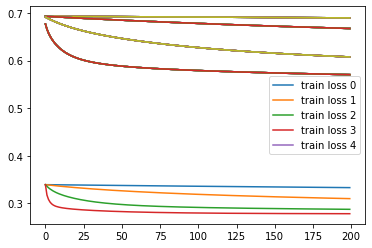

In [19]:

names = [least_squares_GD,least_square, ridge_regression, logistic_regression,reg_logistic_regression]
initial_w  = np.zeros(tX_std.shape[1])
lambdas = np.logspace(-5, 0, 15)
gammas = np.array([0.0001,0.001,0.01,0.1])
degrees = np.array([0,1,2,3,4,5,6,7])
lambda_ = lambdas[0]
gamma = gammas[0]
degree = degrees[0]
bestParametersAccuracyTrain = [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]
bestParametersAccuracyTest = [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]
bestParametersAll= [[names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ],
                   [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ],
                   [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ],
                   [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ],
                   [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]]
for indexML, model_name in enumerate(names):
        print("Done about :" + str(indexML/len(names)))
        if(model_name is least_square or model_name is ridge_regression): #Skip the lambdas
            if(model_name is ridge_regression):
                for indexL,lambda_ in enumerate(lambdas):
                    parameters = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                    wTemp, accTr, accTe = train(names[indexML],y_no_outliers,tX_no_outliers_std,5,None,0,**parameters[indexML])                
                    if accTr > bestParametersAccuracyTrain[4]:    
                        bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                    if accTe > bestParametersAccuracyTest[4]:
                        bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp]
                    if accTe > bestParametersAll[indexML][4]:
                        bestParametersAll[indexML] = [model_name,lambda_, gamma, None, accTe, wTemp]
            else:
                parameteres = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                wTemp, accTr, accTe = train(names[indexML],y_no_outliers,tX_no_outliers_std,5,None,0,**parameters[indexML])                
                if accTr > bestParametersAccuracyTrain[4]:    
                    bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                if accTe > bestParametersAccuracyTest[4]:
                    bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp] 
                if accTe > bestParametersAll[indexML][4]:
                    bestParametersAll[indexML] = [model_name,lambda_, gamma, None, accTe, wTemp]
        else:    
            for indexG,gamma in enumerate(gammas):
                if(model_name is reg_logistic_regression):
                    for indexL,lambda_ in enumerate(lambdas):
                        parameters = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                        wTemp, accTr, accTe = train(names[indexML],y_no_outliers,tX_no_outliers_std,5,None,0,**parameters[indexML])
                        if accTr > bestParametersAccuracyTrain[4]:    
                            bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                        if accTe > bestParametersAccuracyTest[4]:
                            bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp]
                        if accTe > bestParametersAll[indexML][4]:
                            bestParametersAll[indexML] = [model_name,lambda_, gamma, None, accTe, wTemp]
                else:
                    parameters = [{'initial_w': initial_w, 'max_iter':200,'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma}, {'initial_w':initial_w,'max_iter':200,'gamma' : gamma,'lambda_' : lambda_}]
                    wTemp, accTr, accTe = train(names[indexML],y_no_outliers,tX_no_outliers_std,5,None,0,**parameters[indexML])
                    if accTr > bestParametersAccuracyTrain[4]:    
                        bestParametersAccuracyTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                    if accTe > bestParametersAccuracyTest[4]:
                        bestParametersAccuracyTest = [model_name,lambda_, gamma, None, accTe, wTemp] 
                    if accTe > bestParametersAll[indexML][4]:
                        bestParametersAll[indexML] = [model_name,lambda_, gamma, None, accTe, wTemp]
               
                           
                



In [21]:
print(bestParametersAccuracyTrain)
print(bestParametersAccuracyTest)


[<function ridge_regression at 0x000001DE03184DC0>, 0.08483428982440726, 0.1, None, 0.7230126327939637, [array([ 5.38357905e-03, -1.29831427e-01, -1.38653263e-01,  1.39057956e-02,
       -6.29887544e-01,  1.86479876e-01, -2.78249739e+00,  1.64287194e-01,
       -1.05220902e-02,  2.43038663e-03, -5.13045900e-02,  4.70059991e-02,
        6.45498232e+00,  1.32219791e-01, -4.08639501e-04, -1.14839592e-03,
        1.09258118e-01,  7.85157359e-04,  6.70384338e-04,  4.88306486e-02,
        3.83114482e-04, -1.49074611e-02, -7.01170282e-02,  7.93742227e-02,
        2.12565645e-01, -2.29551304e-01,  8.80702045e-02, -1.28228726e+00,
       -1.94215019e+00, -5.55496509e-02]), array([ 3.64005507e-03, -1.29704068e-01, -1.44024480e-01,  2.20919442e-02,
        3.99528350e-01,  1.81243834e-01, -2.84666278e+00,  1.70641467e-01,
       -1.24776787e-02, -1.04697261e-02, -5.06070611e-02,  4.55818171e-02,
        5.23969817e+00,  1.35612637e-01,  2.18573397e-05, -6.31688015e-04,
        1.11851264e-01, -1.

# Create submission

In [ ]:
# load test data
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

tX_test_std = standardize_test(tX, tX_test)
tX_test_std =build_poly(tX_test_std, 2)
OUTPUT_PATH = 'outLogRegD23v2.csv' 
y_pred = predict_labels(np.mean(w_LR,axis=0), tX_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
